# Train Head

In [1]:
from typing import List
import json
from datasets import load_dataset
import sys
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
def extract_output_values(trace):
    results = []

    def recurse(span):
        if isinstance(span, dict):
            if "output.value" in span:
                results.append(str(span["output.value"]))
            for v in span.values():
                recurse(v)
        elif isinstance(span, list):
            for item in span:
                recurse(item)

    recurse(trace)
    return results

In [4]:
!hf auth login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `hf auth whoami` to get more information or `hf auth logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The tok

In [5]:
dataset_name = "PatronusAI/TRAIL"
ds = load_dataset(dataset_name, split="gaia")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.21k [00:00<?, ?B/s]

data/gaia-00000-of-00001-33a2e72d362d688(…):   0%|          | 0.00/33.2M [00:00<?, ?B/s]

data/swe_bench-00000-of-00001-91aa04220f(…):   0%|          | 0.00/21.5M [00:00<?, ?B/s]

Generating gaia split:   0%|          | 0/117 [00:00<?, ? examples/s]

Generating swe_bench split:   0%|          | 0/31 [00:00<?, ? examples/s]

In [6]:
errors = 0
def get_gt_label(example):
    global errors
    labels = example["labels"]

    if isinstance(labels, str):
        try:
            labels = json.loads(labels)
        except json.JSONDecodeError:
            errors += 1
            return None

    scores = labels.get("scores", [])
    overall_values = [ele["overall"] for ele in scores if "overall" in ele]
    print(overall_values)
    example["overall_score"] = np.mean(overall_values) if overall_values else None
    return example

ds = ds.map(get_gt_label)

Map:   0%|          | 0/117 [00:00<?, ? examples/s]

[3.0]
[2.0]
[3.25]
[3.75]
[3.25]
[4.25]
[3.25]
[3.75]
[2.5]
[3.75]
[2.0]
[2.0]
[4.75]
[2.5]
[5]
[3.0]
[2.25]
[2.25]
[3.0]
[3.75]
[2.75]
[3.25]
[3.5]
[3.75]
[4.5]
[3.75]
[3.25]
[4.0]
[4.25]
[3.5]
[2.5]
[2]
[4.75]
[2.75]
[2.5]
[2.75]
[3.25]
[4.25]
[2.0]
[2.25]
[2.75]
[4.0]
[3.25]
[3.25]
[2.0]
[2.88]
[2.25]
[3.25]
[4.25]
[3.25]
[3.75]
[3.5]
[2.5]
[5]
[4.25]
[3.25]
[3.25]
[2.75]
[3.0]
[3.25]
[3.0]
[5]
[3.75]
[5]
[2.75]
[3.75]
[4.0]
[3]
[4.25]
[4.75]
[2.25]
[4.25]
[2.5]
[2.75]
[3.75]
[3.75]
[3.25]
[2.75]
[2.5]
[2.25]
[4.25]
[2.63]
[2.75]
[2.5]
[3.0]
[4.25]
[3.75]
[2.25]
[3.25]
[3.0]
[4.75]
[3.0]
[3.5]
[2.75]
[4.25]
[3.25]
[3.75]
[2.25]
[5]
[2.75]
[2.5]
[3]
[3]
[4.25]
[2.0]
[4.25]
[2.25]
[2]
[5]
[2.5]
[4.75]
[2.0]
[2.75]
[4.75]
[3.5]
[4.25]


In [7]:
def get_output_text(example):
  output_txt = extract_output_values(json.loads(example["trace"]))
  example["output_text"] = "\nNew output: ".join(output_txt)
  return example

ds = ds.map(get_output_text)

Map:   0%|          | 0/116 [00:00<?, ? examples/s]

In [8]:
ds

Dataset({
    features: ['trace', 'labels', 'overall_score', 'output_text'],
    num_rows: 116
})

# 1st possibility: Average embeddings with DistilBert

In [11]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} as device")

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
encoder = DistilBertModel.from_pretrained("distilbert-base-uncased")
encoder.to(device)
encoder.eval()

MAX_LEN = 256
CHUNK_LEN = 256

cls_id = tokenizer.cls_token_id
sep_id = tokenizer.sep_token_id

def get_embedding(example):
    text = example["output_text"]
    token_ids = tokenizer.encode(text, add_special_tokens=False)

    # Chunk the token list
    chunks = [token_ids[i:i+CHUNK_LEN] for i in range(0, len(token_ids), CHUNK_LEN)]
    chunk_embs = []

    for chunk in chunks:
        input_ids = [cls_id] + chunk + [sep_id]
        attention_mask = [1] * len(input_ids)

        input_ids = torch.tensor([input_ids], device=device)
        attention_mask = torch.tensor([attention_mask], device=device)

        with torch.no_grad():
            out = encoder(input_ids=input_ids, attention_mask=attention_mask)

        cls_emb = out.last_hidden_state[:, 0, :]
        chunk_embs.append(cls_emb)

    # Mean across chunks
    final_emb = torch.mean(torch.stack(chunk_embs), dim=0)

    return {"embedding": final_emb.cpu().tolist()}

ds = ds.map(get_embedding, batched=False)


Using cuda as device


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Map:   0%|          | 0/116 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1645 > 512). Running this sequence through the model will result in indexing errors


In [12]:
ds

Dataset({
    features: ['trace', 'labels', 'overall_score', 'output_text', 'embedding'],
    num_rows: 116
})

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


In [14]:
class RegressionHead(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 128], dropout=0.2):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, 1))
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        return self.fc(x)

In [15]:
batch_size = 16
lr = 1e-4
num_epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
n = len(ds)
indices = np.arange(n)
kf = KFold(n_splits=5, shuffle=True, random_state=2)

fold_scores = []
predicted_scores = []

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(indices), 1):
    print(f"-------------Fold {fold_idx}-----------")
    train_ds = ds.select(list(train_idx))
    test_ds = ds.select(list(test_idx))

    X_train = torch.tensor([np.array(e).flatten() for e in train_ds["embedding"]], dtype=torch.float32)
    X_test  = torch.tensor([np.array(e).flatten() for e in test_ds["embedding"]], dtype=torch.float32)


    y_train = torch.tensor(train_ds["overall_score"], dtype=torch.float32).unsqueeze(1)
    y_test = torch.tensor(test_ds["overall_score"], dtype=torch.float32).unsqueeze(1)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

    model = RegressionHead(X_train.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            all_preds.append(preds.cpu())
            all_labels.append(yb.cpu())

    all_preds = torch.cat(all_preds).squeeze().numpy()
    all_labels = torch.cat(all_labels).squeeze().numpy()

    # clamp predictions between 1 and 5
    all_preds = all_preds.clip(1.0, 5.0)
    predicted_scores.append(all_preds)

    mse = ((all_preds - all_labels) ** 2).mean()
    print(f"Fold {fold_idx} MSE: {mse:.4f}")
    fold_scores.append(mse)

print("5-fold CV MSE scores:", fold_scores)
print("Mean MSE:", np.mean(fold_scores))

-------------Fold 1-----------


/tmp/ipython-input-2856433276.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  X_train = torch.tensor([np.array(e).flatten() for e in train_ds["embedding"]], dtype=torch.float32)


Fold 1 MSE: 0.9019
-------------Fold 2-----------
Fold 2 MSE: 0.4531
-------------Fold 3-----------
Fold 3 MSE: 0.9412
-------------Fold 4-----------
Fold 4 MSE: 0.6970
-------------Fold 5-----------
Fold 5 MSE: 0.8182
5-fold CV MSE scores: [np.float32(0.9018952), np.float32(0.4530954), np.float32(0.9411981), np.float32(0.6969617), np.float32(0.81819516)]
Mean MSE: 0.76226914


In [17]:
fold_scores

[np.float32(0.9018952),
 np.float32(0.4530954),
 np.float32(0.9411981),
 np.float32(0.6969617),
 np.float32(0.81819516)]

In [18]:
all_preds = np.concatenate(predicted_scores)
all_labels = np.concatenate([np.array(ds.select(range(len(ds)))["overall_score"])])

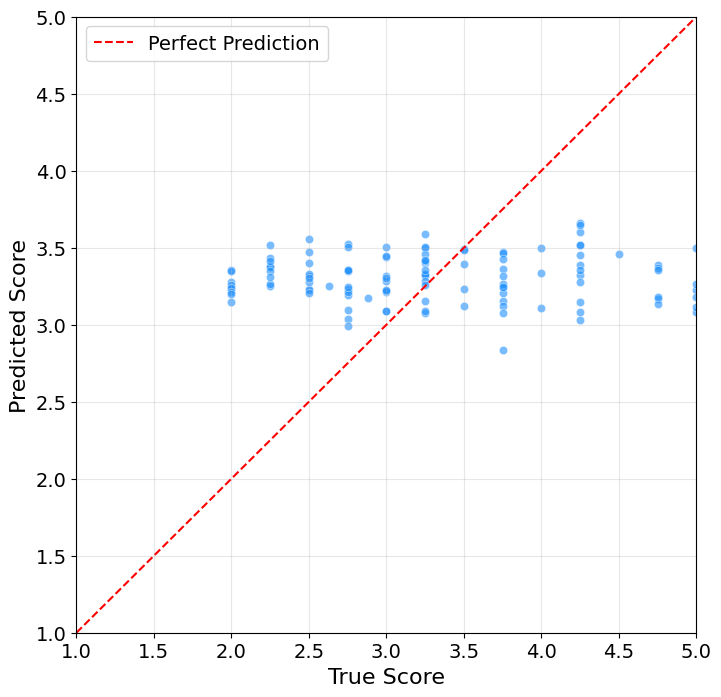

In [19]:
import seaborn as sns
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=18, labelsize=16)
plt.rc('legend', fontsize=14)
plt.figure(figsize=(8,8))

sns.scatterplot(x=all_labels, y=all_preds, alpha=0.6, color='dodgerblue')

# Add diagonal line for perfect prediction
plt.plot([1, 5], [1, 5], 'r--', label="Perfect Prediction")

plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.xlim(1,5)
plt.ylim(1,5)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# 2) Use SentenceTransformers

In [21]:
import torch
import torch.nn as nn
import numpy as np
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model_st = SentenceTransformer("sentence-transformers/paraphrase-mpnet-base-v2").to(device)
tokenizer = model_st.tokenizer

Using device: cuda


In [23]:
TRAIN_MAX_LEN = 128

def embed_with_chunks(text):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    chunks = [
        tokens[i:i+TRAIN_MAX_LEN]
        for i in range(0, len(tokens), TRAIN_MAX_LEN)
    ]

    embeddings = []
    for chunk in chunks:
        chunk_text = tokenizer.decode(chunk)
        emb = model_st.encode(chunk_text, convert_to_tensor=True, device=device)
        embeddings.append(emb)

    return torch.stack(embeddings)   # (num_chunks, 768)

In [33]:
class MultiHeadChunkPooler(nn.Module):
    def __init__(self, dim, n_heads=4):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads

        # multi-head attention: each head has its own scorer
        self.att_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(dim, dim),
                nn.Tanh(),
                nn.Linear(dim, 1)
            ) for _ in range(n_heads)
        ])

    def forward(self, x):
        # x: (num_chunks, dim)
        head_outputs = []

        # Attention pooling for each head
        for scorer in self.att_heads:
            scores = scorer(x)                 # (num_chunks, 1)
            weights = torch.softmax(scores, 0) # (num_chunks, 1)
            pooled = (weights * x).sum(0)      # (dim,)
            head_outputs.append(pooled)

        # Combine all heads
        att_output = torch.cat(head_outputs, dim=-1)  # (dim * n_heads)

        # Add mean pooling
        mean_output = x.mean(dim=0)                   # (dim,)

        # Add max pooling
        max_output = x.max(dim=0).values              # (dim,)

        # Final embedding
        final = torch.cat([mean_output, max_output, att_output], dim=-1)

        return final


In [34]:
def get_embedding(example):
    text = example["output_text"]

    chunk_embs = embed_with_chunks(text)  # (n_chunks, 768)

    return {"chunks": chunk_embs.cpu().tolist()}


ds = ds.map(get_embedding, batched=False)

Map:   0%|          | 0/116 [00:00<?, ? examples/s]

In [35]:
class FullRegressor(nn.Module):
    def __init__(self, dim=768, n_heads=4, hidden_dims=[256, 128], dropout=0.2):
        super().__init__()

        self.pooler = MultiHeadChunkPooler(dim, n_heads)

        pooled_dim = dim * (n_heads + 2)  # mean + max + att_heads

        layers = []
        prev = pooled_dim

        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h

        layers.append(nn.Linear(prev, 1))
        self.reg_head = nn.Sequential(*layers)

    def forward(self, chunks):
        # chunks: (batch, num_chunks, dim)

        pooled_batch = []
        for c in chunks:
            pooled_batch.append(self.pooler(c))

        pooled_batch = torch.stack(pooled_batch)   # (batch, pooled_dim)

        return self.reg_head(pooled_batch)


In [36]:
batch_size = 8
lr = 2e-4
num_epochs = 10
kf = KFold(n_splits=5, shuffle=True, random_state=2)

In [37]:
n = len(ds)
indices = np.arange(n)

fold_scores = []

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(indices), 1):
    print(f"\n===================== FOLD {fold_idx} =====================")

    train_ds = ds.select(list(train_idx))
    test_ds = ds.select(list(test_idx))

    # Convert chunks to tensors
    X_train = [torch.tensor(e) for e in train_ds["chunks"]]
    X_test  = [torch.tensor(e) for e in test_ds["chunks"]]

    y_train = torch.tensor(train_ds["overall_score"], dtype=torch.float32)
    y_test  = torch.tensor(test_ds["overall_score"], dtype=torch.float32)

    # pad chunk counts inside batches
    def collate(batch):
        xs, ys = zip(*batch)
        # pad chunks for batch consistency
        max_len = max(x.shape[0] for x in xs)
        padded = []
        for x in xs:
            pad = max_len - x.shape[0]
            if pad > 0:
                x = torch.cat([x, torch.zeros(pad, x.shape[1])], dim=0)
            padded.append(x)
        return torch.stack(padded), torch.tensor(ys).unsqueeze(1)

    train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True, collate_fn=collate)
    test_loader  = DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False, collate_fn=collate)

    # Model init
    model = FullRegressor(768).to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Training
    model.train()
    for epoch in range(num_epochs):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optim.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optim.step()

    # Eval
    model.eval()
    preds_all, labels_all = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb).cpu().squeeze()
            preds_all.append(out)
            labels_all.append(yb.squeeze())

    preds = torch.cat(preds_all).numpy()
    labels = torch.cat(labels_all).numpy()

    preds = preds.clip(1.0, 5.0)

    mse = ((preds - labels)**2).mean()
    fold_scores.append(mse)
    print(f"Fold {fold_idx} MSE: {mse:.4f}")

print("\n===== FINAL RESULTS =====")
print("5-fold MSEs:", fold_scores)
print("Mean MSE:", np.mean(fold_scores))



===================== FOLD 1 =====================
Fold 1 MSE: 0.6966

===================== FOLD 2 =====================
Fold 2 MSE: 0.5923

===================== FOLD 3 =====================
Fold 3 MSE: 0.7081

===================== FOLD 4 =====================
Fold 4 MSE: 0.6311

===================== FOLD 5 =====================
Fold 5 MSE: 0.7128

===== FINAL RESULTS =====
5-fold MSEs: [np.float32(0.6966131), np.float32(0.5923463), np.float32(0.70810896), np.float32(0.6310567), np.float32(0.7128237)]
Mean MSE: 0.66818976


In [38]:
fold_scores

[np.float32(0.6966131),
 np.float32(0.5923463),
 np.float32(0.70810896),
 np.float32(0.6310567),
 np.float32(0.7128237)]

In [39]:
all_preds = np.concatenate(predicted_scores)
all_labels = np.concatenate([np.array(ds.select(range(len(ds)))["overall_score"])])

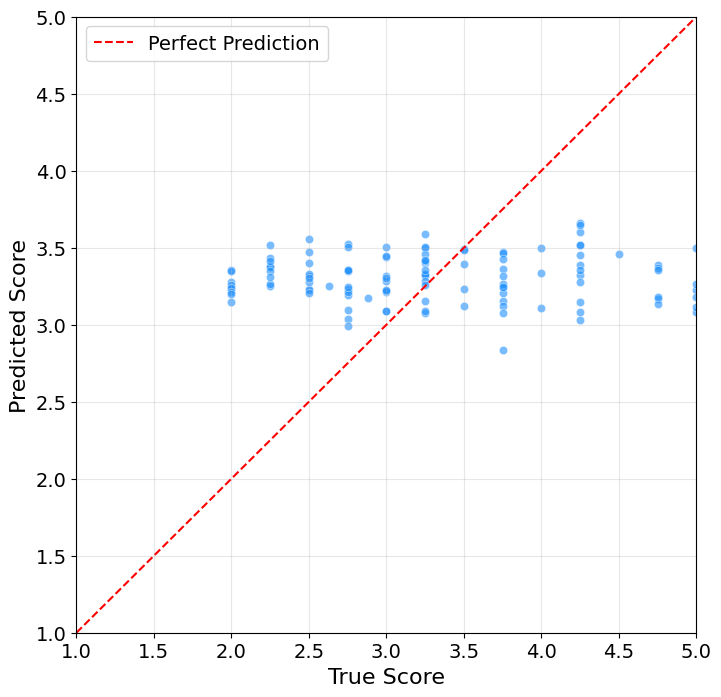

In [40]:
import seaborn as sns
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=18, labelsize=16)
plt.rc('legend', fontsize=14)
plt.figure(figsize=(8,8))

sns.scatterplot(x=all_labels, y=all_preds, alpha=0.6, color='dodgerblue')

# Add diagonal line for perfect prediction
plt.plot([1, 5], [1, 5], 'r--', label="Perfect Prediction")

plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.xlim(1,5)
plt.ylim(1,5)
plt.grid(alpha=0.3)
plt.legend()
plt.show()